# ===Importing libraries we may need=== 

In [3]:
from copy import deepcopy
import torch
import torch.optim.lr_scheduler as lr_scheduler

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler
from torchinfo import summary

import time
import os
import zipfile
from copy import deepcopy

import import_ipynb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
NUM_WORKERS = os.cpu_count()

from torchvision import datasets, transforms
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import logging
from omegaconf import DictConfig, OmegaConf

cuda:0


# ===Utility Functions===

In [4]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

In [5]:
from torchsampler import ImbalancedDatasetSampler

## ===TRANSFORMATIONS & DATALOADERS===

In [6]:

    
input_size=224

train_transformations= transforms.Compose([transforms.CenterCrop(input_size),
                                     transforms.RandomRotation(90),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)), #try
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])



""""
train_transformations = transforms.Compose([
        # transforms.ToPILImage(), # not needed since the image already np.array
        transformsoT.Tensor(),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
"""
valid_transformations= transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])



test_transformations= transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    
    
    

def train_dataloader(train_dir: str,
                     transform: transforms.Compose,
                     batch_size: int,
                     num_workers: int=NUM_WORKERS
                           ):
    train_data= datasets.ImageFolder(train_dir,transform=transform)
    
    
    classes= train_data.classes
    
    
    train_dataloader = DataLoader(
        
        train_data,
        sampler=ImbalancedDatasetSampler(train_data),
        batch_size=batch_size,
        #shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        
     )
   
    
    return train_dataloader , classes



def validate_dataloader(validation_dir: str,
                        transform: transforms.Compose,
                        batch_size: int,
                        num_workers: int=NUM_WORKERS
                           ):
    validation_data= datasets.ImageFolder(validation_dir,transform=transform)
    #classes= validation_data.classes

    validation_dataloader = DataLoader(
        validation_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        
     )
    
    return validation_dataloader #classes



def test_dataloader(test_dir: str,
                            transform: transforms.Compose,
                            batch_size: int,
                            num_workers: int=NUM_WORKERS
                           ):
    test_data= datasets.ImageFolder(test_dir,transform=transform)
    test_dataloader = DataLoader(
        
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        
     )
    
    return test_dataloader



# ===setup the paths===

In [7]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
path = "C:/Users/Mohamme/Desktop/Augmentation/data/Data"
data_path = Path(path)
image_path = data_path / "data"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
    
    
    
# Setup Dirs
train_dir = image_path / "C:/Users/Mohamme/Desktop/Augmentation/data/Data/train"
validation_dir = image_path / "C:/Users/Mohamme/Desktop/Augmentation/data/Data/val"
test_dir="C:/Users/Mohamme/Desktop/Augmentation/data/Data/test"




#Create Transformers
#train_transformations, valid_transformations, test_transformations = data_transformation()

#create Datasets
train_data,  class_names = train_dataloader(train_dir=train_dir,transform=train_transformations, batch_size=32)
validation_data= validate_dataloader(validation_dir=validation_dir,transform=valid_transformations,batch_size=32)
test_data=test_dataloader(test_dir=test_dir,transform=test_transformations,batch_size=32)

In [8]:
train_data, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e953031790>,
 ['Barred Spiral',
  'Cigar Shaped Smooth',
  'Disturbed',
  'Edge-on with Bulge',
  'Edge-on without Bulge',
  'Merging',
  'Round Smooth',
  'Smooth, Cigar shaped',
  'Unbarred Loose Spiral',
  'Unbarred Tight Spiral'])

# ===Training pipeline===

In [9]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          epochs: int,
          patience: int,
          delta:float,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    patience: Maximum limit of epochs where testing loss increases
    delta: Difference between one epoch to the next
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    min_test_loss = 10
    counter = 0
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        # Step the learning rate scheduler at each epoch
        scheduler.step()

        if(test_loss < min_test_loss):
            min_test_loss = test_loss
            counter = 0
        elif(test_loss >= (min_test_loss + delta)):
            counter += 1
            if (counter >= patience):
                return results
                break

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"min_test_loss: {min_test_loss:.4f} | "
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

# ===Download The model & view the summary=== 


# Getting a summary of our model with torchinfo.summary()

## We use torchinfo to learn more about the model we are using: To do so, we'll pass in:

    1- model - the model we'd like to get a summary of.
    2- input_size - the shape of the data we'd like to pass to our model.
    3- col_names - the various information columns we'd like to see about our model.
    4- col_width - how wide the columns should be for the summary.
    5- row_settings - what features to show in a row.



In [13]:
DensNet=torchvision.models.densenet121(pretrained=True)

DensNet

for param in DensNet.parameters():
    
    param.requires_grad=False
    
    
for param in DensNet.features.denseblock3.parameters():
    param.requires_grad=True
    
    
    
for param in DensNet.features.denseblock4.parameters():
    param.requires_grad=True


    

num_ftrs = DensNet.classifier.in_features
DensNet.classifier = nn.Linear(num_ftrs, 10)


'''
dense_block_4 = DensNet.features.denseblock4


dropout_probability = 0.5
dense_block_4.denselayer4 = nn.Sequential(
    dense_block_4.denselayer4,
    nn.Dropout(dropout_probability)
)
'''





'''
dense_block_3=DensNet.features.denseblock3
dropout_probability2 = 0.1

dense_block_3.denselayer3 = nn.Sequential(
    dense_block_3.denselayer3,
    nn.Dropout(dropout_probability2))

'''




num_ftrs = DensNet.classifier.in_features
dropout_prob = 0.5  # You can adjust the dropout probability as needed
DensNet.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    #nn.Dropout(dropout_prob),
    nn.Linear(512, 256),
    nn.ReLU(),
    #nn.Dropout(dropout_prob),
    nn.Linear(256, 10),  # Assuming num_classes is the number of output classes
    nn.LogSoftmax(dim=1)  # Use LogSoftmax for classification
)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)





In [14]:

#old lr = 0.0001
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(DensNet.parameters(), lr=0.0001,weight_decay=0.1)

scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=10,gamma=0.1)


# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [16]:


# Print a summary using torchinfo (uncomment for actual output)
input_size = (32, 3, 224, 224)
summary(model=DensNet, 
        input_size= input_size, 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
) 



Layer (type (var_name))                       Input Shape Output Shape Param #    Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224] [32, 10]   --         Partial
├─Sequential (features)                       [32, 3, 224, 224] [32, 1024, 7, 7] --         Partial
│    └─Conv2d (conv0)                         [32, 3, 224, 224] [32, 64, 112, 112] (9,408)    False
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112] [32, 64, 112, 112] (128)      False
│    └─ReLU (relu0)                           [32, 64, 112, 112] [32, 64, 112, 112] --         --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112] [32, 64, 56, 56] --         --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56] [32, 256, 56, 56] --         False
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56] [32, 32, 56, 56] (45,440)   False
│    │    └─_DenseLayer (denselayer2)         [32, 64, 56, 56] [32, 32, 56, 56] (49,600)   False
│    │    └─_DenseLayer (de



# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(DensNet.parameters(), lr=1e-4, betas=(0.9, 0.999))




# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device



In [17]:
from timeit import default_timer as timer 
start_time = timer()
rresults =train(model=DensNet,
                       train_dataloader=train_data,
                       test_dataloader=validation_data,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       scheduler=scheduler,
                       epochs=35,
                       patience=3,
                       delta=0.05,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {(end_time-start_time)/60:.3f} minutes")
print(f"[INFO] Total training time: {(end_time-start_time)/3600:.3f} hours")

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1104 | train_acc: 0.6241 | test_loss: 0.7682 | test_acc: 0.7355 | min_test_loss: 0.7682 | 
Epoch: 2 | train_loss: 0.7350 | train_acc: 0.7494 | test_loss: 0.6592 | test_acc: 0.7708 | min_test_loss: 0.6592 | 
Epoch: 3 | train_loss: 0.6717 | train_acc: 0.7701 | test_loss: 0.6632 | test_acc: 0.7801 | min_test_loss: 0.6592 | 
Epoch: 4 | train_loss: 0.5929 | train_acc: 0.7962 | test_loss: 0.6493 | test_acc: 0.7784 | min_test_loss: 0.6493 | 
Epoch: 5 | train_loss: 0.5653 | train_acc: 0.8057 | test_loss: 0.6250 | test_acc: 0.7858 | min_test_loss: 0.6250 | 
Epoch: 6 | train_loss: 0.5463 | train_acc: 0.8121 | test_loss: 0.6088 | test_acc: 0.7907 | min_test_loss: 0.6088 | 
Epoch: 7 | train_loss: 0.5166 | train_acc: 0.8218 | test_loss: 0.5915 | test_acc: 0.7996 | min_test_loss: 0.5915 | 
Epoch: 8 | train_loss: 0.5130 | train_acc: 0.8241 | test_loss: 0.6565 | test_acc: 0.7871 | min_test_loss: 0.5915 | 
Epoch: 9 | train_loss: 0.4901 | train_acc: 0.8317 | test_loss: 0.5460 | 

In [ ]:
# ===

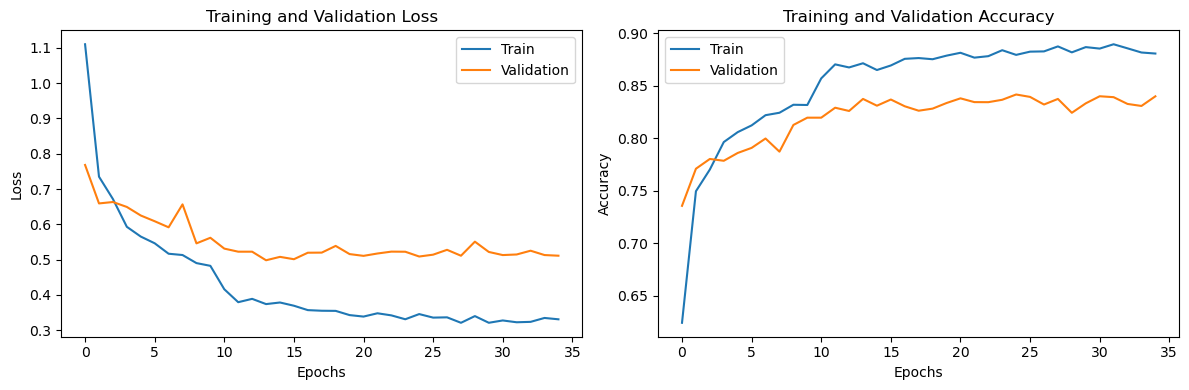

In [18]:
def plot_metrics(results):
    epochs = len(results['train_loss'])
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), results['train_loss'], label='Train')
    plt.plot(range(epochs), results['test_loss'], label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), results['train_acc'], label='Train')
    plt.plot(range(epochs), results['test_acc'], label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# To use this function, call it after training and testing:

# Assuming 'training_results' contains your training results
plot_metrics(rresults)


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_evaluation_metrics(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            predicted = torch.argmax(outputs, dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# To use this function, call it after training:

# Assuming 'trained_model' is your trained PyTorch model
# 'test_dataloader' is your test DataLoader
print_evaluation_metrics(DensNet, test_data, device)


Accuracy: 0.8474
Precision: 0.8477
Recall: 0.8474
F1 Score: 0.8464


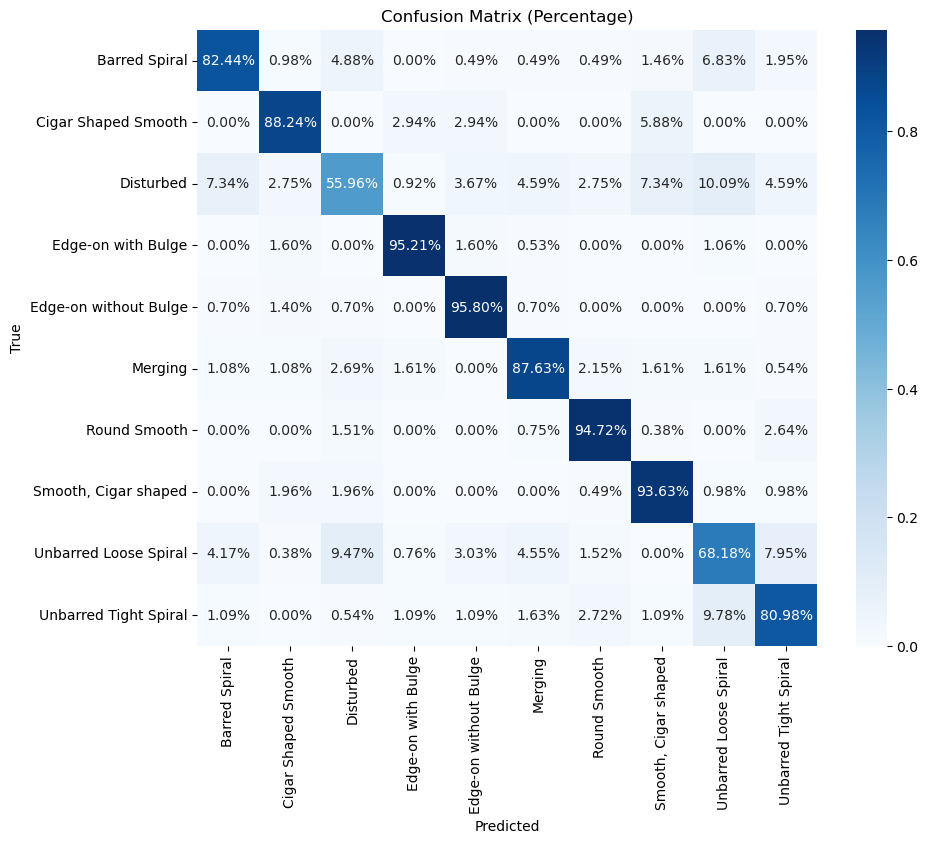

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            predicted = torch.argmax(outputs, dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Calculate percentages

    plt.figure(figsize=(10, 8))  # Adjust the figsize for a larger matrix
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

# To use this function, call it after training:

# Define your class names for the confusion matrix
class_names = ['Barred Spiral',
               'Cigar Shaped Smooth',
               'Disturbed',
               'Edge-on with Bulge',
               'Edge-on without Bulge',
               'Merging','Round Smooth',
               'Smooth, Cigar shaped',
               'Unbarred Loose Spiral',
               'Unbarred Tight Spiral']  # Replace with your actual class names

# Assuming 'trained_model' is your trained PyTorch model
# 'test_dataloader' is your test DataLoader
plot_confusion_matrix(DensNet, test_data, device, class_names)


In [20]:
train_data, class_names

(<torch.utils.data.dataloader.DataLoader at 0x13dd35be050>,
 ['Barred Spiral',
  'Cigar Shaped Smooth',
  'Disturbed',
  'Edge-on with Bulge',
  'Edge-on without Bulge',
  'Merging',
  'Round Smooth',
  'Smooth, Cigar shaped',
  'Unbarred Loose Spiral',
  'Unbarred Tight Spiral'])

In [21]:
torch.save(DensNet.state_dict(), 'D121.pth')